In [ ]:
import json
import re
import numpy as np
import anthropic
import requests
from bs4 import BeautifulSoup
import nest_asyncio
import asyncio
from playwright.async_api import async_playwright
from markdownify import markdownify as md
import yaml

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [1]:
ads_token = "6pmanBZytaNltPsonmdbJATGnDZO7mAxluAxgYfz"

In [912]:
from urllib.parse import urlencode, quote_plus

query = {"q": "bibstem:ara&a", "fl": "title, year, bibcode, identifier", "rows":1}

encoded_query = urlencode(query)

results = requests.get("https://api.adsabs.harvard.edu/v1/search/query?{}".format(encoded_query), \
                       headers={'Authorization': 'Bearer ' + ads_token})

json_results = results.json()

In [265]:
with open('araa.json', 'w') as f:
    json.dump(json_results, f)

In [3]:
with open('araa.json', 'r') as f:
    json_results = json.load(f)

In [53]:
def pull_arxiv_and_doi(idlist):
    arXiv_pattern = r'arXiv:\d{4}\.\d{4}'
    arxiv, doi = "", ""
    for item in idlist:
        if re.match(arXiv_pattern, item):
            arxiv = item.split('arXiv:')[1]
        elif '10.1146/annurev' in item:
            doi = item
    return arxiv, doi

In [54]:
def format_reviews(json_docs, cutoff = 2000):
    all_reviews = []
    for result in json_docs:
        if int(result['year']) > cutoff:
            arxiv, doi = pull_arxiv_and_doi(result['identifier'])
            if doi != "" and arxiv != "":
                url = "https://www.annualreviews.org/content/journals/" + doi
                all_reviews.append({'title': result['title'][0], "id": arxiv, 'url': url, })
    return all_reviews

In [913]:
reviews = format_reviews(json_results['response']['docs'])

In [190]:
review_list = ["""{ "title": "Circumbinary Accretion: From Binary Stars to Massive Binary Black Holes",
                "id": "2211.00028",
                "url": "https://www.annualreviews.org/content/journals/10.1146/annurev-astro-052622-022933"} """,
                """{ "title": "Hydrodynamical Simulations of the Galaxy Population: Enduring Successes and Outstanding Challenges",
                "id": "2309.17075",
                "url": "https://www.annualreviews.org/content/journals/10.1146/annurev-astro-041923-043618"}"""]

In [191]:
reviews = [json.loads(text) for text in review_list]

In [322]:
!ls

araa.json             computer-vision       raptor
araa_evals.ipynb      ir-tutorial-notebooks
argubot               jhu-mt-hw


In [8]:
with open("/users/christineye/retrieval/config.yaml", 'r') as stream:
    api_key = yaml.safe_load(stream)['anthropic_api_key']

In [9]:
client = anthropic.Anthropic(api_key = api_key)

def generate_query(text):
    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=100,
        temperature=0,
        system="""You are an expert astronomer. Given a paragraph from a scientific paper, return a specific research query that the paragraph answers.
                    Formulate the question such that it is focused and concise, but covers all topics in the paragraph. 
                    Be concise and return just the question.""",
        messages=[{ "role": "user", 
                   "content": [{   "type": "text",  "text": text, } ]}]
    )
    
    return message.content[0].text

In [24]:
generate_query(review["text"])

'What do numerical simulations reveal about the formation and evolution of circumbinary accretion disks around binary massive black holes following galaxy mergers?'

In [10]:
import requests

def download_html(url):
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:106.0) Gecko/20100101 Firefox/106.0')
    req.add_header('Accept', 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8')
    req.add_header('Accept-Language', 'en-US,en;q=0.5')

    r = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(r, features="html.parser")
    
    return soup.get_text()

In [11]:
nest_asyncio.apply()

async def fetch_page_content(url):
    async with async_playwright() as playwright:
        browser = await playwright.chromium.launch(headless=False)  # Set headless=True if you don't need a browser UI
        context = await browser.new_context()
        page = await context.new_page()

        await page.goto(url)
        await page.wait_for_load_state('networkidle')

        content = await page.content()

        await browser.close()
        
        soup = BeautifulSoup(content, 'html.parser')
        
        paragraphs = [md(p.text) for p in soup.find_all('p')]
        
        return paragraphs

async def fetch_multiple_pages(urls):
    tasks = [fetch_page_content(url) for url in urls]
    return await asyncio.gather(*tasks)

def get_page_contents(reviews):
    urls = [review["url"] for review in reviews]
    return asyncio.run(fetch_multiple_pages(urls))

In [12]:
def scrape_citations(text):
    patterns = ['([A-Z][a-z´]+)\s+(\d{4})', # Name Year
                '([A-Z][a-z´]+) et al\. (\d{4})', # Name et al. Year
                '([A-Z][a-z´]+) et al\. \((\d{4})\)', # Name et al. (Year)
                '([A-Z][a-z´]+) & ([A-Z][a-z]+) (\d{4})', # Name & Name Year
                '([A-Z][a-z´]+) & ([A-Z][a-z]+) \((\d{4})\)',
                '([A-Z][a-z´]+),\s+([A-Z][a-z]+) & ([A-Z][a-z]+) (\d{4})']
    
    citations = []
    for pattern in patterns:
        for match in re.findall(pattern, text):
            citations.append(match)
    
    return citations

In [13]:
def citation_density(content, k, mode = "topk", maxn = 12):
    num_citations = np.array([len(scrape_citations(p)) for p in content])
    
    if mode == "topk":
        indices = np.flip(np.argsort(num_citations))[:k]
    elif mode == "threshold":
        mask = np.logical_and(num_citations >= k, num_citations < maxn)
        indices = np.arange(len(content))[mask]
    
    return np.sort(indices)

In [14]:
def get_best_paragraphs(content, k, mode = "threshold"):
    indices = citation_density(content, k, mode)
    string = ""
    
    for index in indices:
        string += str(index)
        string += ": "
        string += content[index]
        string += "\n\n"
    
    return string

In [137]:
def claude_paragraphs(paper):
    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=500,
        temperature=0,
        system="""You are an expert astronomer. Given this list of paragraphs from a scientific paper, generate a focused research question for each paragraph.
                Formulate the question such that it is focused and concise, but covers all topics in the paragraph. 
                Then assess which paragraphs are most on-topic and closely related to their research question.
                If the question has multiple sub-questions, a good and focused paragraph shoudl address all of them.
                Return the 3 best question-paragraph pairs in this format: (index, question).
                Do not include any text before or after each (index, question), including any introduction or rationale.""",
                # Also return the 3 paragraphs and corresponding questions that are least on-topic and related to the research question.
        messages=[{"role": "user",
                "content": [{"type": "text", "text": paper,}] }]
    )
    
    return message

In [30]:
len(reviews) # only after 2000; only with arXiv

161

In [75]:
batch_size = 5

for i in range(len(reviews) // batch_size + 1)[29:]:
    print(i)
    batch = reviews[i * batch_size : i * batch_size + (batch_size - 1)]
    content = get_page_contents(batch)

    for j, paper in enumerate(content):
        if "institutional or personal subscription" not in paper[-1]:
            review = reviews[i * batch_size + j].copy()
            review['text'] = paper
            reviews_with_text.append(review)

29


Task exception was never retrieved
future: <Task finished name='Task-2622' coro=<Connection.run() done, defined at /Users/christineye/anaconda3/lib/python3.9/site-packages/playwright/_impl/_connection.py:265> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/Users/christineye/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kg/0g3xrys53nd6r_vs_7tph9y00000gn/T/ipykernel_4675/2564133765.py", line 7, in <module>
    content = get_page_contents(batch)
  File "/var/folders/kg/0g3xrys53nd6r_vs_7tph9y00000gn/T/ipykernel_4675/4225371177.py", line 28, in get_page_contents
    return asyncio.run(fetch_multiple_pages(urls))
  File "/Users/christineye/anaconda3/lib/python3.9/site-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "/Users/christineye/anaconda3/lib/python3.9/site-packages/nest_asyncio.py", line 92, 

30
31
32


In [833]:
with open('araa_papers.json', 'w') as f:
    for paper in reviews_with_text:
        paper_json = json.dumps(paper, indent = 2)
        f.write(paper_json)
        f.write('\n')

In [37]:
reviews[:10]

[{'title': 'The Chemical Composition of the Sun',
  'id': '0909.0948',
  'url': 'https://www.annualreviews.org/content/journals/10.1146/annurev.astro.46.060407.145222'},
 {'title': 'Coevolution (Or Not) of Supermassive Black Holes and Host Galaxies',
  'id': '1304.7762',
  'url': 'https://www.annualreviews.org/content/journals/10.1146/annurev-astro-082708-101811'},
 {'title': 'Cosmic Star-Formation History',
  'id': '1403.0007',
  'url': 'https://www.annualreviews.org/content/journals/10.1146/annurev-astro-081811-125615'},
 {'title': 'Star Formation in the Milky Way and Nearby Galaxies',
  'id': '1204.3552',
  'url': 'https://www.annualreviews.org/content/journals/10.1146/annurev-astro-081811-125610'},
 {'title': 'The Circumgalactic Medium',
  'id': '1709.09180',
  'url': 'https://www.annualreviews.org/content/journals/10.1146/annurev-astro-091916-055240'},
 {'title': 'Observational Evidence of Active Galactic Nuclei Feedback',
  'id': '1204.4114',
  'url': 'https://www.annualreviews.o

In [236]:
message = claude_paragraphs(get_best_paragraphs(contents[1], 5))

In [245]:
message.content[0].text.split('\n\n')[1]

'(9, How have cosmological simulations of galaxy formation improved over time in reproducing observed galaxy properties, and what key challenges remain?)'

In [238]:
print(message.content[0].text)

Here are the 3 best question-paragraph pairs based on relevance and focus:

(9, How have cosmological simulations of galaxy formation improved over time in reproducing observed galaxy properties, and what key challenges remain?)

(55, How do cosmological simulations model the multiphase structure of the interstellar medium given resolution limitations?)

(151, What are the main limitations of current state-of-the-art cosmological simulations of galaxy formation, and what key physical processes are still neglected?)


In [164]:
papers[1]

{'title': 'Theory of Star Formation',
 'id': '0707.3514',
 'url': 'https://www.annualreviews.org/content/journals/10.1146/annurev.astro.45.051806.110602',
 'text': ['We use cookies to track usage and preferences.I Understand',
  'We review current understanding of star formation, outlining an overall theoretical framework and the observations that motivate it. A conception of star formation has emerged in which turbulence plays a dual role, both creating overdensities to initiate gravitational contraction or collapse, and countering the effects of gravity in these overdense regions. The key dynamical processes involved in star formation—turbulence, magnetic fields, and self-gravity—are highly nonlinear and multidimensional. Physical arguments are used to identify and explain the features and scalings involved in star formation, and results from numerical simulations are used to quantify these effects. We divide star formation into large-scale and small-scale regimes and review each in 

In [ ]:
# ask it to consider time?

In [251]:
def process_paragraphs(content):
    paragraphs = get_best_paragraphs(content, 5)
    message = claude_paragraphs(paragraphs)
    message = message.content[0].text
    
    results = []
    for pair in message.split('\n\n'):
        if '(' in pair:
            index, question = pair[1:-1].split(',', 1)
            paragraph = content[int(index)]
            results.append({'question': question, 'paragraph': paragraph, 'citations': scrape_citations(paragraph)})
    
    return results

In [145]:
len(set(scrape_citations(papers[0]['text'][93])))

9

In [1035]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import multi_paper

In [708]:
review_json = multi_paper.load_araa(from_file = True)
reviews = multi_paper.format_reviews(review_json)
print('Number of reviews:', len(reviews))

Number of reviews: 189


In [712]:
from tqdm import tqdm

In [724]:
batch_size = 10

for i in tqdm(range(len(reviews) // batch_size + 1)[13:]):
    batch = reviews[i * batch_size : i * batch_size + (batch_size - 1)]
    content = multi_paper.get_page_contents(batch)

    for j, paper in enumerate(content):
        
        paper['paragraphs'] = [re.sub('\(#right-ref-[A-Za-z0-9]+\)', '', p) for p in paper['paragraphs']]
        
        if "institutional or personal subscription" not in paper['paragraphs'][-1]:
            if review['title'] not in [rev['title'] for rev in reviews_with_text]:
                review = reviews[i * batch_size + j].copy()
                review['text'] = paper['paragraphs']
                review['fullbib'] = paper['references']
                reviews_with_text.append(review)

100%|█████████████████████████████████████████████| 6/6 [04:37<00:00, 46.30s/it]


In [727]:
[rev['title'] for rev in reviews_with_text]

['Cosmic Star-Formation History',
 'The Circumgalactic Medium',
 'The Galaxy in Context: Structural, Kinematic, and Integrated Properties',
 'Small-Scale Challenges to the ΛCDM Paradigm',
 'Intermediate-Mass Black Holes',
 'Relativistic Jets from Active Galactic Nuclei',
 'Hot Accretion Flows Around Black Holes',
 'Magnetars',
 'Understanding Galaxy Evolution Through Emission Lines',
 'The Coevolution of Galaxies and Supermassive Black Holes: Insights from Surveys of the Contemporary Universe',
 'The Faintest Dwarf Galaxies',
 'Quasars and the Intergalactic Medium at Cosmic Dawn',
 'Masses, Radii, and the Equation of State of Neutron Stars',
 'The Assembly of the First Massive Black Holes',
 'Galaxy Formation and Reionization: Key Unknowns and Expected Breakthroughs by the James Webb Space Telescope',
 'Key Physical Processes in the Circumgalactic Medium',
 'The First Stars: Formation, Properties, and Impact',
 'Observations of Protoplanetary Disk Structures',
 'Revisiting the Unified 

In [725]:
with open('araa_papers.json', 'w') as f:
    json.dump(reviews_with_text, f)

In [803]:
print('Number of papers:', len(reviews_with_text))

query_pairs = []
for i, paper in enumerate(reviews_with_text):
    print(i)
    query_pairs.append(multi_paper.process_paper(paper))

Number of papers: 94
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your daily rate limit (https://docs.anthropic.com/en/api/rate-limits); see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

In [942]:
ref = {"surnames": ["Savage", "Spangler", "Fischer"], "year": "2013", "collab": None}

In [943]:
multi_paper.search_arxiv(ref)

first_author:Savage author:Spangler author:Fischer year:2013
[{'bibcode': '2013ApJ...765...42S', 'author': ['Savage, Allison H.', 'Spangler, Steven R.', 'Fischer, Patrick D.'], 'identifier': ['10.1088/0004-637X/765/1/42', '2013ApJ...765...42S', 'arXiv:1206.5173', '2012arXiv1206.5173S', '10.48550/arXiv.1206.5173'], 'title': ['Probing the Rosette Nebula Stellar Bubble with Faraday Rotation'], 'year': '2013'}]
['10.1088/0004-637X/765/1/42', '2013ApJ...765...42S', 'arXiv:1206.5173', '2012arXiv1206.5173S', '10.48550/arXiv.1206.5173']


'1206.5173'

In [952]:
for j, paper in tqdm(enumerate(query_pairs)):
    if j > 47:
        multi_paper.arxiv_link(query_pairs[j])
        print(j, query_pairs[j][0]['arxiv'])

49it [00:07,  6.14it/s]

48 ['0501638', '0509413', '0407037', '0609798', '0306121', '1010.3702']



50it [00:16,  2.43it/s]

49 ['0607560', '0406054', '1701.04640', '1703.09544', '1701.07160', '1708.07292', '0803.1214', '0803.1214']



51it [01:04,  2.26s/it]

50 ['0606242', '1501.03681', '0502543', '1304.0674', '1307.3558', '1204.0009', '0904.0603', '0910.1107']
Failed on Dawson 2008



52it [01:13,  2.62s/it]

51 ['1511.05853', '0810.2556', '1105.6097', '1101.1296', '1204.5570', '1105.3073', '1810.12158', '1207.4837', '1105.4605']



53it [01:30,  3.59s/it]

52 ['1211.2803', '1201.3635', '0510310', '2007.06580', '1405.4040', '1312.4970', '1401.5471', '1210.3346']



54it [01:35,  3.69s/it]

53 ['1102.1748']
Failed on Popov 2010



55it [01:47,  4.64s/it]

54 ['1505.05893', '1808.03710', '1404.2934', '1604.03909', '1405.5945', '1611.00458', '1810.04354', '1711.08110']



56it [02:01,  6.02s/it]

55 ['1610.07263', '1204.1073', '0809.0311', '0911.2032', '0204175', '1507.06998', '1202.6063', '0406304', '1110.4866', '2103.15707', '1904.12048', '1503.05561', '1605.01730']



57it [02:12,  6.76s/it]

56 ['0803.1924', '1106.0496', '1011.0426', '1011.0430', '0003465', '0710.2697', '1710.03002', '1710.10271', '0202204']



58it [02:18,  6.62s/it]

57 ['1307.8115', '1709.00763', '1209.0625', '1610.02401', '1701.03094', '2007.15742']



59it [02:30,  7.91s/it]

58 ['1402.1237', '0908.0700', '1602.03837', '1505.06712', '1805.09640', '1305.2099', '1809.04605', '1209.0455', '1206.5443', '1112.0944']



60it [02:34,  6.94s/it]

59 ['1407.5062']



61it [02:49,  9.04s/it]

60 ['0807.1134', '0906.2536', '0907.1389', '0906.3704', '0111384', '1002.3469', '0204034']
Failed on Boogert 2015



62it [02:54,  7.81s/it]

61 ['0301488', '0608003', '0809.2094', '1309.6489', '0304489', '0211342']
62 []



64it [02:56,  5.01s/it]

63 ['2007.06488']



65it [03:05,  6.00s/it]

64 ['1510.06960', '1201.2052', '0904.1938', '1511.08425', '1602.03056', '1601.00004', '1308.2914', '1612.08453', '1805.00802']



66it [03:08,  5.23s/it]

65 []
Failed on Blazek 2017
Failed on Troxel 2017



67it [03:23,  7.65s/it]

66 ['1501.07897', '1503.03757', '1406.1506', '1510.03962', '0003014', '0101213', '0003008', '1707.01072', '0609591', '1606.05338', '1609.09085', '1110.3193', '1704.05858', '1507.05598']



68it [03:47, 12.12s/it]

67 ['1710.05863', '1710.05856', '1710.05444', '1710.05455', '1710.05459', '1710.06426', '1710.05431', '1903.08173', '1806.10596', '1903.06712', '1710.05854', '1710.05864', '1710.05457', '1710.05446', '1710.05843', '1805.11829', '1710.05461', '1710.05437', '1710.05452', '1710.05433', '1710.05435', '1710.05449']



69it [04:12, 15.74s/it]

68 ['1307.2259', '1306.2314', '0003365', '1208.4417', '1102.1891', '1104.0712', '0604358', '0411072', '0501562', '1310.2253', '0407372']



70it [04:16, 12.60s/it]

69 ['1502.06296', '1504.00142', '1106.0931', '0301558', '1510.04664', '1206.5173']



71it [04:24, 11.01s/it]

70 ['1802.08213', '0308272', '0908.3017', '1502.01027', '0602038', '0311060', '1405.2041', '1607.05289', '1504.07010', '1403.0007', '0705.0973', '0403293']



72it [04:38, 12.02s/it]

71 ['0309134', '0311060']



73it [04:43,  9.88s/it]

72 ['0003421', '0802.2033', '0706.1713', '0706.1713']



74it [04:47,  8.09s/it]

73 ['0405052', '1210.1209']



75it [05:03, 10.55s/it]

74 ['0910.0059', '1611.09353', '1702.05494', '1609.08145', '1701.02596', '0709.0302', '1211.2003', '1208.3217', '1204.1891', '0112051', '1803.01875', '1001.1156', '1710.05843', '1103.5165', '0612408', '0612617']
Failed on Cawthon 2020
Failed on Stölzner 2020



76it [05:10,  9.58s/it]

75 ['2001.03621', '0609591', '2104.06774', '1805.12574', '1704.05988']



77it [05:15,  8.05s/it]

76 ['0606352', '0708.0148']
Failed on Schultheis 2017



78it [05:30, 10.23s/it]

77 ['1302.1613', '1212.2317', '1308.0593', '1007.5065', '1008.0519', '0502316', '1301.0638']



79it [05:35,  8.48s/it]

78 ['0005557', '1201.4483', '0111385']



80it [05:42,  8.29s/it]

79 ['1511.05985', '1612.06309', '1609.07283', '1704.03465', '1703.04027', '1609.07416', '1708.01949', '1804.06394', '1612.07355']
80 []
Failed on Wasserstein 2016



82it [05:45,  5.16s/it]

81 []



83it [05:54,  5.93s/it]

82 ['0112251', '0301219', '0201098', '0308547']



84it [05:59,  5.70s/it]

83 ['9903384']



85it [06:03,  5.25s/it]

84 ['1511.02313', '0912.0953', '1202.4001']



86it [06:17,  7.69s/it]

85 ['1005.4037', '1410.4199', '1409.1904', '1703.01424', '1501.03798', '1608.00620', '9911436']



87it [06:30,  9.24s/it]

86 []
Failed on Aghanim 2020
Failed on Weiner 2019



88it [06:47, 11.62s/it]

87 ['1801.05235', '1212.5225', '0608407', '1603.00464', '0003365', '2004.09487', '0306515']



89it [07:04, 13.17s/it]

88 ['1510.00977', '1801.05983', '1811.00461', '1410.5660', '1404.0670', '1501.06708']
Failed on Nidever 2010



90it [07:08, 10.30s/it]

89 []


91it [07:15,  4.79s/it]

90 ['0011465', '1001.2965', '1301.0540', '0608471', '0805.0691', '0811.0163', '0411447', '0603444', '1110.4638']


In [877]:
# van den Bosch, van de Voort, Planck Collab
# can't distinguish between multiple identical author lists in the same year. could query volume but that's annoying

In [957]:
fname = '../data/multi_paper_examples.json'
with open(fname, 'w') as json_file:
    for paper in query_pairs:
        for entry in paper:
            partial_json = json.dumps({k: v for k, v in entry.items() if k not in ['arxiv', 'citations', 'bibs']}, indent = 2)
            if 'arxiv' in entry:
                arxiv_json = json.dumps(list(entry['arxiv']), separators=(',', ':'))
            else:
                arxiv_json = ""
            citations_json = json.dumps(entry['citations'], separators=(',', ':'))
            combined_json = partial_json.rstrip('}') + ', "citations": ' + citations_json + ',\n "arxiv": ' + arxiv_json + '\n}'
            json_file.write(combined_json)
            json_file.write('\n')

In [1000]:
query_pairs_formatted = {}
for paper in query_pairs:
    for i, query in enumerate(paper):
        if query['id'] == "":
            id_str = query['title'].split(' ')[0] + '_' + str(i + 1)
        else:
            id_str = query['id'].split('_')[0] + '_' + str(i + 1)
        query_pairs_formatted[id_str] = {'title':query['title'], 'question':query['question'], 
                                        'text': query['paragraph'], 'citations':query['citations'],
                                        'arxiv': list(query['arxiv'])}

In [1004]:
with open('../data/multi_paper.json', 'w') as f:
    json.dump(query_pairs_formatted, f, indent = 2)

In [1001]:
len(query_pairs_formatted)

273

In [960]:
fname = '../data/multi_paper_examples.json'
with open(fname, 'w') as json_file:
    for paper in query_pairs:
        for entry in paper:
            partial_json = json.dumps({k: v for k, v in entry.items() if k not in ['arxiv', 'citations', 'bibs']}, indent = 2)
            if 'arxiv' in entry:
                arxiv_json = json.dumps(list(entry['arxiv']), separators=(',', ':'))
            else:
                arxiv_json = ""
            citations_json = json.dumps(entry['citations'], separators=(',', ':'))
            combined_json = partial_json.rstrip('}') + ', "citations": ' + citations_json + ',\n "arxiv": ' + arxiv_json + '\n}'
            json_file.write(combined_json)
            json_file.write('\n')

In [473]:
def link_to_arxiv(review, citations):
    cited_refs = []
    for citation in set(citations):
        for ref in review['fullbib']:
            if ref['year'] == citation[-1]:
                if set(citation[:-1]).issubset(ref['surnames']) or citation[0] == ref['collab']:
                    cited_refs.append(ref)
    
    return cited_refs

In [743]:
cited_refs = multi_paper.link_to_bib(reviews_with_text[0], citations)

In [744]:
cited_refs

[{'surnames': ['Guedes', 'Callegari', 'Madau', 'Mayer'],
  'year': '2011',
  'collab': None},
 {'surnames': ['Dubinski', 'Carlberg'], 'year': '1991', 'collab': None},
 {'surnames': ['Klypin', 'Trujillo-Gomez', 'Primack'],
  'year': '2011',
  'collab': None},
 {'surnames': ['Blumenthal', 'Faber', 'Primack', 'Rees'],
  'year': '1984',
  'collab': None},
 {'surnames': ['Hopkins', 'Quataert', 'Murray'],
  'year': '2012',
  'collab': None},
 {'surnames': ['Kuhlen', 'Krumholz', 'Madau', 'Smith', 'Wise'],
  'year': '2012',
  'collab': None},
 {'surnames': ['Stadel', 'Potter', 'Moore'], 'year': '2009', 'collab': None},
 {'surnames': ['Di Matteo', 'Springel', 'Hernquist'],
  'year': '2005',
  'collab': None},
 {'surnames': ['Springel', 'White', 'Jenkins'],
  'year': '2005',
  'collab': None},
 {'surnames': ['Ocvirk', 'Pichon', 'Teyssier'],
  'year': '2008',
  'collab': None},
 {'surnames': ['Hernquist', 'Springel'], 'year': '2003', 'collab': None},
 {'surnames': ['Springel', 'Hernquist'], 'year

In [ ]:
len(query_pairs)

In [350]:
import arxiv
arxiv_client = arxiv.Client()

In [686]:
def search_arxiv(ref):
    #print(ref)
    query = ""
    for i, surname in enumerate(ref['surnames']):
        if '-' not in surname: query += "au:"
        query += surname.replace("'","")
        
        if i != len(ref['surnames']) - 1: query += " AND "
    #query += ref['year'] doesn't work super well
    search = arxiv.Search(query = query, max_results = 10)
    results = arxiv_client.results(search)
    
    for r in results:
        
        valid = True
        if r.published.year > int(ref['year']) + 2 or r.published.year < int(ref['year']) - 2:
            continue
        for i, surname in enumerate(ref['surnames']):
            if surname not in r.authors[i].name:
                valid = False
                break
        if valid: return r.entry_id.split('/')[-1]
    return None

In [687]:
cited_refs[5]

{'surnames': ['Amaro-Seoane', 'Gair', 'Pound', 'Hughes', 'Sopuerta'],
 'given_names': ['P', 'JR', 'A', 'SA', 'CF'],
 'year': '2015',
 'source': 'J. Phys. Conf. Ser.',
 'collab': None}

In [688]:
search_arxiv(cited_refs[2])

'http://arxiv.org/abs/1307.6556v1'

In [674]:
for r in arxiv_client.results(arxiv.Search(query="Amaro-Seoane AND au:Gair AND au:Pound AND au:Hughes AND au:Sopuerta")):
    print(r)

http://arxiv.org/abs/1410.0958v1


In [ ]:
# special characters 
# dashes

In [15]:
import multi_paper

test


In [54]:
reviews = multi_paper.load_araa(from_file = True)

In [55]:
reviews_with_text = multi_paper.scrape_all_papers(reviews, from_web = True)

  0%|          | 0/19 [00:00<?, ?it/s]/Users/christineye/anaconda3/envs/jsalt-retrieval/lib/python3.10/site-packages/markdownify/__init__.py:96: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, 'html.parser')
100%|██████████| 19/19 [20:46<00:00, 65.59s/it]


In [56]:
with open('./multi_data/araa_papers.json', 'w', encoding='utf-8') as file:
    for item in reviews_with_text:
        json.dump(item, file)
        file.write('\n')

In [1080]:
best_sentences = multi_paper.get_best_sentences_from_paper(reviews_with_text[0]['text'], mode = "threshold", k = 5)

In [1078]:
best_sentences[0]

('The “dark side” of galaxy formation can be modeled with high accuracy and has been explored in detail through N-body numerical simulations of increasing resolution and size (,    , 2008   ).',
 [('Stadel', '2009'),
  ('Dubinski', 'Carlberg', '1991'),
  ('Klypin', '2011'),
  ('Diemand', '2008'),
  ('Davis', '1985'),
  ('Moore', '1999'),
  ('Springel', '2005')])

In [1084]:
multi_paper.process_paper_sentences(reviews_with_text[0])

[{'title': 'Cosmic Star-Formation History',
  'id': '1403.0007',
  'question': 'Research question: How do parameter uncertainties and degeneracies in semianalytic models and subgrid implementations of galaxy formation affect the predictive power of these approaches?',
  'paragraph': ('The purely phenomenological treatment of complex physical processes that is at the core of semianalytic schemes of galaxy formation (  ) and—at a much higher level of realism—the “subgrid modeling” of star formation and stellar feedback that must be implemented even in the more accurate cosmological hydrodynamic simulations (      ) are sensitive to poorly determined parameters and suffer from various degeneracies, a weakness that has traditionally prevented robust predictions to be made in advance of specific observations.',
   [('Ocvirk', '2008'),
    ('White', 'Frenk', '1991'),
    ('Agertz', '2013'),
    ('Keres', '2005'),
    ('Katz', '1996'),
    ('Springel', 'Hernquist', '2003'),
    ('Governato', 

In [1076]:
n_citations = [len(sentence[1]) for sentence in best_sentences]

(array([2., 1., 2., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.]),
 <BarContainer object of 10 artists>)

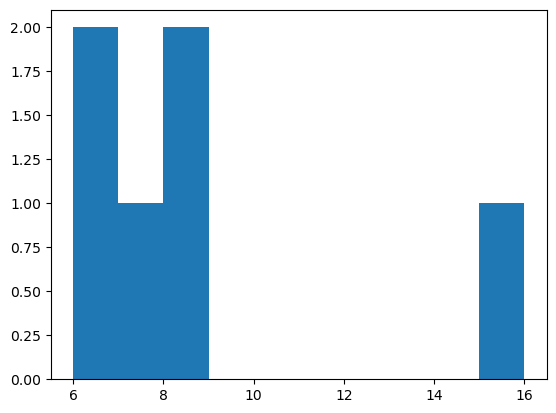

In [1077]:
import matplotlib.pyplot as plt
plt.hist(n_citations)

In [1102]:
for i, paper in enumerate(papers):
    print(paper['title'])

Cosmic Star-Formation History
The Circumgalactic Medium
The Galaxy in Context: Structural, Kinematic, and Integrated Properties
Small-Scale Challenges to the ΛCDM Paradigm
Intermediate-Mass Black Holes
Relativistic Jets from Active Galactic Nuclei
Hot Accretion Flows Around Black Holes
Magnetars
Understanding Galaxy Evolution Through Emission Lines
The Coevolution of Galaxies and Supermassive Black Holes: Insights from Surveys of the Contemporary Universe
The Faintest Dwarf Galaxies
Quasars and the Intergalactic Medium at Cosmic Dawn
Masses, Radii, and the Equation of State of Neutron Stars
The Assembly of the First Massive Black Holes
Galaxy Formation and Reionization: Key Unknowns and Expected Breakthroughs by the James Webb Space Telescope
Key Physical Processes in the Circumgalactic Medium
The First Stars: Formation, Properties, and Impact
Observations of Protoplanetary Disk Structures
Revisiting the Unified Model of Active Galactic Nuclei
Accretion onto Pre-Main-Sequence Stars
The

In [1112]:
papers = multi_paper.load_papers(from_file = True)
print('Number of papers:', len(papers))

query_pairs = []
for paper in papers:
    print(paper['title'])
    query_pairs.append(multi_paper.process_paper_sentences(paper, verbose = True, mode = "threshold", k = 5))

Number of papers: 138
Cosmic Star-Formation History
6
The Circumgalactic Medium
10
The Galaxy in Context: Structural, Kinematic, and Integrated Properties
8
Small-Scale Challenges to the ΛCDM Paradigm
7
Intermediate-Mass Black Holes
9
Relativistic Jets from Active Galactic Nuclei
1
Hot Accretion Flows Around Black Holes
10
Magnetars
2
Understanding Galaxy Evolution Through Emission Lines
10
The Coevolution of Galaxies and Supermassive Black Holes: Insights from Surveys of the Contemporary Universe
8
The Faintest Dwarf Galaxies
10
Quasars and the Intergalactic Medium at Cosmic Dawn
5
Masses, Radii, and the Equation of State of Neutron Stars
5
The Assembly of the First Massive Black Holes
10
Galaxy Formation and Reionization: Key Unknowns and Expected Breakthroughs by the James Webb Space Telescope
9
Key Physical Processes in the Circumgalactic Medium
5
The First Stars: Formation, Properties, and Impact
10
Observations of Protoplanetary Disk Structures
10
Revisiting the Unified Model of 

In [1125]:
for paper in query_pairs:
    for i, query in enumerate(paper):
        if query['id'] is None:
            id_str = query['title'].split(' ')[0] + '_' + str(i + 1)
        else:
            id_str = query['id'].split('_')[0] + '_' + str(i + 1)
        query_pairs_formatted[id_str] = {'title': query['title'], 'question':query['question'], 
                                        'text': query['paragraph'], 'citations':query['citations'],
                                        'arxiv': list(query['arxiv'])}

    
    with open('../data/multi_paper_sentences.json', 'w') as f:
        json.dump(query_pairs_formatted, f, indent = 2)

In [1155]:
ref = {"surnames": ["Kopparapu", "Ramirez", "Schottel Kotte"], "year": "2014", "collab": None}
multi_paper.search_arxiv(ref)

{'error': 'Too many requests'}
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/christineye/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kg/0g3xrys53nd6r_vs_7tph9y00000gn/T/ipykernel_4675/3272684116.py", line 2, in <module>
    multi_paper.search_arxiv(ref)
  File "/Users/christineye/retrieval/evaluation/multi_paper.py", line 197, in search_arxiv
    json_results = query_ads(ref, verbose, incyear = True)
  File "/Users/christineye/retrieval/evaluation/multi_paper.py", line 177, in query_ads
    json_results = results.json()['response']['docs']
KeyError: 'response'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/christineye/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/christineye/anaconda3/lib/python3.

In [1150]:
for j, query in tqdm(enumerate(query_pairs)):
    if j > 46 and len(query) > 0:
        multi_paper.arxiv_link(query_pairs[j])
        print(j, query_pairs[j][0]['arxiv'])

0it [00:00, ?it/s]

Failed on Rice 2005


49it [00:03, 12.98it/s]

48 ['0407037', '0501638', '0609798', '0306121', '1010.3702']
49 ['1908.11290', '1808.08753', '1711.05736', '1607.08733', '1802.02977', '1605.02562', '1512.00416', '1703.03252', '2001.06400', '1611.07314']


51it [00:19,  1.96it/s]

50 ['1101.4670', '1110.6225', '1005.1714', '1503.01111', '0910.2990', '0606242', '1205.4100', '1107.3616', '1010.2290', '1409.6762']


52it [00:24,  1.44it/s]

51 []


53it [00:29,  1.16it/s]

52 ['2104.08986', '2009.03568', '1007.1052', '0702365', '1902.04689', '1610.07616', '0610929', '1308.3147']


54it [00:33,  1.09s/it]

53 ['0211274', '0503021']
Failed on Popov 2010


55it [00:40,  1.64s/it]

54 ['1409.5516', '1409.4031', '1710.02302', '1701.01109', '1604.05336', '1408.1333', '1703.09232', '1307.1409']


56it [00:56,  3.29s/it]

55 ['1805.03202', '1808.02204', '9702060', '1702.07818', '1608.07642', '9910061', '1602.04531', '1602.04226', '1906.07726', '1912.08218', '2009.10068', '1602.03831', '1203.2938']


57it [01:02,  3.58s/it]

56 ['1009.5471', '1403.3693', '1110.1722', '1405.4869', '1107.3159', '1808.01847', '1308.5985', '1901.11045', '2003.12083', '1709.00991', '1404.4632', '1208.6031']


58it [01:07,  3.83s/it]

57 ['1103.4543', '1211.3112', '1509.04004', '1004.3698', '0912.4426', '1005.5166', '1603.00291', '1110.6224', '1011.5327', '1212.5026', '1009.4740']


59it [01:11,  3.92s/it]

58 ['1604.01022', '0206233', '1904.04687', '1401.5474', '1807.04293', '1903.01762', '1507.04000']


60it [01:12,  3.30s/it]

59 ['1904.11436', '2105.04500', '2007.12959', '1908.04246', '1503.03070']


61it [01:17,  3.73s/it]

60 []


62it [01:20,  3.49s/it]

61 ['0711.2536', '9504100', '1407.3279', '9803199']
62 []


64it [01:22,  2.40s/it]

63 ['2105.04533', '1602.04964', '1605.03955', '1912.12300']


65it [01:25,  2.67s/it]

64 ['1611.06955', '1805.07100', '1604.02680', '1504.02119', '1610.06184']
Failed on Kenchington Goldsmith 2017


66it [01:39,  5.28s/it]

65 ['1709.10107', '1603.06948', '2007.00716', '2012.05947', '2107.06366']
Failed on Blazek 2017


67it [01:49,  6.70s/it]

66 ['1702.05301', '1704.01054', '0112441', '0809.5035', '0910.3786', '1612.00852', '9712115', '0508296', '0208256', '1611.04954', '0911.2244', '1707.06640', '0206182']


68it [02:12, 10.97s/it]

67 ['1710.05433', '1710.05452', '1710.05850', '1710.05854', '1710.05863', '1710.05840', '1710.05455', '1710.05461', '1710.05448', '1710.05459', '1710.05841', '1710.05462', '1710.05843', '1710.05858', '1710.05856', '1710.05437', '1710.05443', '1710.05864', '1710.05440', '1710.05846', '1710.05444', '1710.05844', '1710.05848', '1710.05432']
Failed on Gontcho 2014


69it [02:31, 13.39s/it]

68 ['9409017', '9701209', '9806286', '9507047', '9511013', '9704184', '9509106', '9509105', '9508133']


70it [02:36, 10.79s/it]

69 ['1508.05153', '1304.1279', '1001.5230']
Failed on Lacerda 2020


71it [03:00, 14.85s/it]

70 ['1605.07626', '1104.0525', '1005.2959', '1308.4271', '1202.0511']


72it [03:07, 12.56s/it]

71 ['2007.11977', '1606.01304', '1805.11621', '1808.03059', '1905.04314', '2002.11117', '1806.01741', '1903.09649', '1803.03655', '1803.02340', '1905.06434', '1809.09637', '2010.07545', '1606.00053']


74it [03:09,  7.13s/it]

73 []


75it [03:12,  6.11s/it]

74 ['0612617', '1001.1156', '0612408', '0709.0302']
Failed on Perucho 2014


77it [03:16,  4.57s/it]

76 ['1612.06929', '1506.04754', '1510.04023', '1904.03243', '1512.04526', '1709.09397', '1512.05026', '1805.11039', '1810.03613', '1904.04923', '1508.02721']
Failed on McWilliam 2003
Failed on Schultheis 2017


78it [03:26,  5.79s/it]

Failed on Schultheis 2017
77 ['0807.1463', '1310.4108', '1611.08612', '1801.06157', '0604592', '0311082', '1306.0954']


79it [03:28,  4.85s/it]

78 []
Failed on Feltzing 2018


80it [03:33,  4.87s/it]

79 ['1807.09773', '1207.2388', '1808.05863', '1409.0568', '1609.02914', '1507.03604', '1807.09784', '1506.06095', '1507.00027', '1309.2631', '1109.5670', '1804.00673', '1612.07622']
80 []


82it [03:35,  3.10s/it]

81 ['1301.3168', '1309.0809', '0912.3693', '1501.02227', '1408.1787', '1406.4130', '1405.7435']


83it [03:38,  3.26s/it]

82 ['9803167', '9709055', '9806313', '1405.7364', '9909475', '9811062', '1301.7422', '1405.1028', '9710156', '1502.05050']
Failed on Hara 2018


85it [03:42,  2.61s/it]

84 ['0511841', '1206.6097']
Failed on Ehrenreich 2006
Failed on Snellen 2013
Failed on Kopparapu 2014
Failed on Ehrenreich 2006
Failed on Noack 2016
Failed on Simon 2009
Failed on Meadows 2016
Failed on Meadows 2016


86it [04:07,  2.88s/it]

85 ['1401.5323', '1701.07513', '1702.08618', '1602.05176', '1307.0515', '1208.5028', '1608.02536', '0503520', '1403.2713', '1302.4566', '0710.5294']


KeyError: 'response'

In [ ]:
# improved keyword search
# metadata

In [1167]:
query_pairs_formatted = {}
for paper in query_pairs[:83]:
    for i, query in enumerate(paper):
        if query['id'] == "":
            id_str = query['title'].split(' ')[0] + '_' + str(i + 1)
        else:
            id_str = query['id'].split('_')[0] + '_' + str(i + 1)
        if type(query['arxiv']) == set:
            query['arxiv'] = list(query['arxiv'])
        query_pairs_formatted[id_str] = {'title': query['title'], 'question':query['question'], 
                                        'text': query['paragraph'], 'citations':query['citations'],
                                        'arxiv': query['arxiv']}

AttributeError: 'NoneType' object has no attribute 'split'

In [1165]:
type(query['arxiv'])

list